demo for class


In [64]:
# import os
# import torch
# import itertools
# os.environ['TORCH'] = torch.__version__
# os.environ['PYTHONWARNINGS'] = "ignore"
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch-geometric
# !pip3 install kmeans1d
# from torch_geometric.data import Data
# import torch.nn.functional as F
# from torch.nn import Linear
# import torch_geometric.transforms as T
# import sys
# import random
# import numpy as np
# import time
# import math
# import csv
# import datetime
# import math
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import pandas as pd
# import glob
# import random
# import torch.nn as nn
# import torch.optim as optim
# from collections import defaultdict
# from tqdm.notebook import tqdm
# from math import exp
# from chardet import detect
# from torch_geometric.nn.conv import MessagePassing
# from torch_geometric.utils import degree
# from sklearn import preprocessing as pp
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import scipy.sparse as sp
# from networkx.algorithms import bipartite
# import kmeans1d
# import copy
# from google.colab import drive

In [ ]:
# --- 표준 라이브러리 ---
import os, sys, math, time, random, copy, glob, csv, datetime, itertools
from collections import defaultdict

# --- 과학 연산 / 시각화 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.sparse as sp

# --- PyTorch & PyG ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

# --- 기타 ---
from tqdm import tqdm
from chardet import detect
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import bipartite
import kmeans1d

# --- Device 선택 (Apple Silicon M4) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# MPS 미지원 연산 자동 CPU fallback 허용
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

print("Using device:", device)

Using device: mps


In [38]:
# hyperparameters
latent_dim = 64   # length of user/item embedding
num_layer = 2   # num.hop neighbor
rating_threshold = 4
batch_size = 300
epochs = 2000
learning_rate = 5e-4
decay = 5e-4
topK = 3 # num. top recommend
dropout = 0.2
sample_rate = 0.2  # test size, train whole set

In [39]:
# df = pd.read_csv('food2.csv')
df = pd.read_csv('book.csv')
print("*"*50)
print("Original dataset info.")
print(f"  Number of ratings = {len(df)}")
print(f"  Number of users = {df['user'].nunique()}")
print(f"  Number of items = {df['item'].nunique()}")

# --- 1. 평점 기반 필터링 ---
# rating_threshold 이상의 평점만 "긍정적 상호작용"으로 간주합니다.
df = df[df['rating'] >= rating_threshold]
print(f"After rating filtering (>= {rating_threshold}):")
print(f"  Number of ratings = {len(df)}")
print(f"  Number of users = {df['user'].nunique()}")
print(f"  Number of items = {df['item'].nunique()}")
print("*"*50)


# --- 2. 코어 필터링 (Core Filtering) ---
# 상호작용이 너무 적은 사용자(cold-user)와 아이템(cold-item)을 제거하여 데이터의 품질을 높입니다.
# 이는 모델이 의미 있는 패턴에 더 집중하도록 도와줍니다.
min_interactions = 4  # 최소 상호작용 횟수 (이 값을 5, 10, 20 등으로 조절하며 실험)

while True:
    # 필터링 전 데이터 개수 기록
    original_rows = df.shape[0]
    
    # 아이템 필터링: min_interactions 미만의 상호작용을 가진 아이템 제거
    item_counts = df.groupby('item').size()
    df = df[df['item'].isin(item_counts[item_counts >= min_interactions].index)]
    
    # 사용자 필터링: min_interactions 미만의 상호작용을 가진 사용자 제거
    user_counts = df.groupby('user').size()
    df = df[df['user'].isin(user_counts[user_counts >= min_interactions].index)]
    
    # 필터링 후 데이터 개수 확인
    filtered_rows = df.shape[0]
    
    # 더 이상 데이터가 줄어들지 않으면 루프 종료
    if original_rows == filtered_rows:
        break

print(f"After Core-Filtering (>= {min_interactions} interactions):")
print(f"  Number of ratings = {len(df)}")
print(f"  Number of users = {df['user'].nunique()}")
print(f"  Number of items = {df['item'].nunique()}")
print("*"*50)


# --- 3. 인덱싱 (Label Encoding) ---
# 코어 필터링으로 사용자/아이템이 제거되었으므로, 인덱스를 0부터 다시 연속적으로 부여합니다.
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
df['user_idx'] = le_user.fit_transform(df['user'].values)
df['item_idx'] = le_item.fit_transform(df['item'].values)


# --- 4. 훈련 / 테스트 데이터 분리 ---
# 전처리가 완료된 전체 데이터를 훈련셋과 테스트셋으로 나눕니다.
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, validation_df = train_test_split(train_val_df, test_size=0.25, random_state=42) # 0.8 * 0.25 = 0.2


print("After data splitting:")
print(f"  Train set size: {len(train_df)}")
print(f"  Test set size: {len(test_df)}")
print("*"*50)


# --- 5. 최종 파라미터 정의 ---
# 모델은 전체 사용자/아이템 수를 알아야 임베딩 레이어를 만들 수 있습니다.
# LabelEncoder의 classes_를 사용하면 정확한 개수를 얻을 수 있습니다.
num_user = len(le_user.classes_)
num_item = len(le_item.classes_)

# user_ids와 item_ids는 평가 단계에서 score matrix의 인덱스로 사용될 수 있습니다.
user_ids = le_user.classes_
item_ids = le_item.classes_

**************************************************
Original dataset info.
  Number of ratings = 64112
  Number of users = 5560
  Number of items = 45747
After rating filtering (>= 4):
  Number of ratings = 27689
  Number of users = 4075
  Number of items = 22052
**************************************************
After Core-Filtering (>= 4 interactions):
  Number of ratings = 572
  Number of users = 66
  Number of items = 105
**************************************************
After data splitting:
  Train set size: 342
  Test set size: 115
**************************************************


LightGCN link prediction


100%|██████████| 2000/2000 [00:07<00:00, 274.06it/s]


        006000438X  014028009X  038548951X  039592720X  043935806X  \
243       1.080183   -0.039434    1.471408    0.744394   -0.791250   
244       1.515667   -0.000443    1.131729    0.507836   -0.456955   
254       0.942696   -1.053353    1.546645   -1.542377    2.678522   
638      -0.421934   -0.062686    0.262874    0.355624   -1.721931   
805      -0.187261   -2.150065    0.745704    4.191924   -2.320242   
...            ...         ...         ...         ...         ...   
277427   -0.232090   -0.470923   -0.116220   -0.825426    0.532787   
277965    0.226566    3.331652   -0.845641   -0.796682   -0.147145   
278356    0.349795   -0.682527    0.707830   -2.235363    5.659447   
278633    1.009502    0.262981   -0.237420    0.619524   -0.922270   
278843    0.858879    4.801031   -0.945000   -1.331215    0.574089   

        044023722X  059035342X  067976402X  068484267X  068484477X  ...  \
243       5.646246   -0.339964   -0.221139    0.115058   -1.203084  ...   
244      

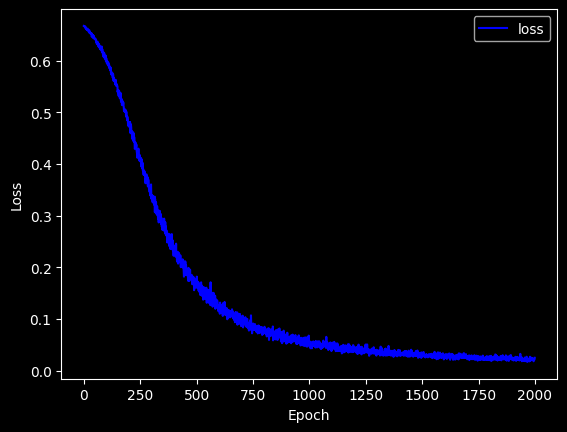

In [40]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + posEmb0.norm().pow(2) + negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss

def data_loader(data, batch_size, n_usr, n_itm):
    # data는 이제 train_df를 의미합니다.
    interected_items_df = data.groupby('user_idx')['item_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # [수정] 전체 사용자 ID(n_usr)가 아닌, 실제 학습 데이터에 있는 사용자 ID 목록에서 샘플링합니다.
    unique_users_in_data = data['user_idx'].unique()

    if len(unique_users_in_data) < batch_size:
        # 중복을 허용하여 batch_size만큼 샘플링합니다.
        users = random.choices(unique_users_in_data, k=batch_size)
    else:
        # 중복 없이 샘플링합니다.
        users = random.sample(list(unique_users_in_data), batch_size)

    users.sort()
    users_df = pd.DataFrame(users, columns=['users'])
    
    # [수정] 이제 merge는 항상 성공하며 NaN이 발생하지 않습니다.
    # 기존 interected_items_df에 없는 user가 없기 때문입니다.
    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_idx', right_on='users')
    
    # x가 NaN이 될 가능성이 사라졌으므로 에러가 발생하지 않습니다.
    pos_items = interected_items_df['item_idx'].apply(lambda x: random.choice(x)).values
    neg_items = interected_items_df['item_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

class LightGCN(nn.Module):
    def __init__(self, data, n_user, n_item, n_layers, latent_dim=32):
        super(LightGCN, self).__init__()
        print("LightGCN link prediction")
        self.data = data
        self.num_user = n_user
        self.num_item = n_item
        self.num_layer = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.num_user + self.num_item, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.num_user, self.num_item), dtype = np.float32)
        R[self.data['user_idx'], self.data['item_idx']] = 1.0

        adj_mat = sp.dok_matrix((self.num_user + self.num_item, self.num_user + self.num_item), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: self.num_user, self.num_user :] = R
        adj_mat[self.num_user :, : self.num_user] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Below Code is toconvert the dok_matrix to sparse tensor.
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape
        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor


    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.num_layer):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.num_user, self.num_item])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [self.num_user, self.num_item])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed


    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0


# train model
# model = LightGCN(df_train, num_user, num_item, num_layer, latent_dim)
model = LightGCN(train_df, num_user, num_item, num_layer, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_list_epoch = []
for epoch in tqdm(range(epochs)):
    n_batch = int(len(train_df)/batch_size)
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    model.train()
    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        # users, pos_items, neg_items = data_loader(df_train, batch_size, num_user, num_item)
        users, pos_items, neg_items = data_loader(train_df, batch_size, num_user, num_item)
        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.forward(users, pos_items, neg_items)
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
        reg_loss = decay * reg_loss
        final_loss = mf_loss + reg_loss
        final_loss.backward()
        optimizer.step()
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

    model.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = model.propagate_through_layers()

    loss_list_epoch.append(round(np.mean(final_loss_list),4))


score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
df_score = pd.DataFrame(score, index=user_ids, columns = item_ids)
print(df_score)


# loss graph
losses_np = np.array(loss_list_epoch)
epoch_range = np.arange(1,epochs)
plt.plot(losses_np, color='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

✅ Model training finished.

Evaluating ranking performance for 50 users...


Ranking Evaluation: 100%|██████████| 50/50 [00:00<00:00, 15207.77it/s]



      RECOMMENDATION EVALUATION ANALYSIS

### 1. Qualitative Analysis (Recommendation Example) ###

  👤 Random User ID: 243
  ✅ Actual Liked Items (in Test Set):
     ['60977493' '316601950']
  🤖 Model's Top-10 Recommendations:
     ['312243022' '743418174' '671646575' '60934417' '60977493' '60987103'
 '038548951X' '142001740' '156027321' '156007754']
  🎯 Successful Hits:
     ['60977493']

### 2. Quantitative Analysis (Overall Performance) ###

  ✅ Precision@10: 0.0560
     => 추천된 10개 중 정답 비율의 평균
  ✅ Recall@10:    0.2325
     => 실제 정답 중 추천 목록에 포함된 비율의 평균
  ✅ NDCG@10:      0.1634
     => 순서까지 고려한 추천 품질 (1에 가까울수록 좋음)
  ✅ Hit Rate@10:  0.4000
     => 추천 목록에 정답이 1개 이상 포함된 사용자의 비율


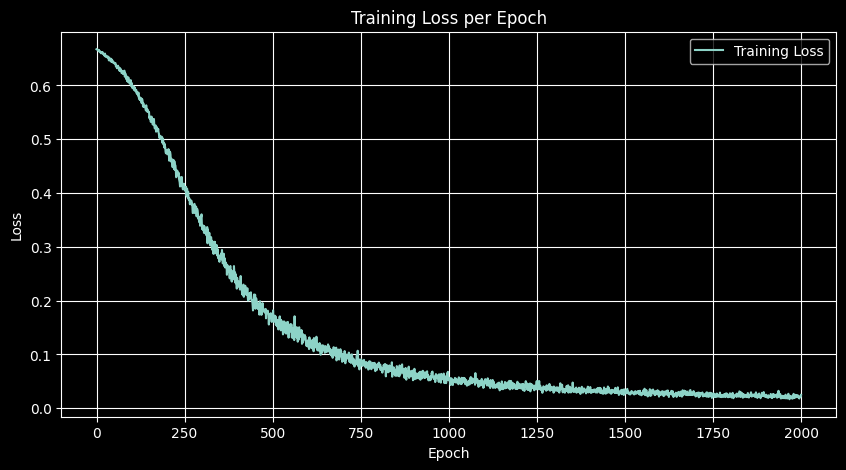

In [41]:
# --- 1. 분석 기능이 추가된 평가 함수 정의 ---

def evaluate_model_analytically(model, train_df, test_df, k=10):
    """
    추천 시스템의 성능을 Precision@K, Recall@K, NDCG@K, Hit Rate@K로 평가하고,
    분석을 위한 추가 정보를 함께 반환합니다.
    """
    model.eval()
    
    with torch.no_grad():
        final_user_embed, final_item_embed, _, _ = model.propagate_through_layers()
        final_user_embed = final_user_embed.cpu()
        final_item_embed = final_item_embed.cpu()

    test_true = test_df.groupby('user_idx')['item_idx'].apply(list).to_dict()
    train_history = train_df.groupby('user_idx')['item_idx'].apply(list).to_dict()
    
    test_users = list(test_true.keys())
    
    precisions, recalls, ndcgs, hit_counts = [], [], [], 0
    
    # 질적 분석을 위한 첫 번째 사용자의 결과 저장
    qualitative_analysis_data = None

    print(f"\nEvaluating ranking performance for {len(test_users)} users...")
    for i, user_idx in enumerate(tqdm(test_users, desc="Ranking Evaluation")):
        true_items = set(test_true.get(user_idx, []))
        if not true_items:
            continue

        scores = torch.matmul(final_user_embed[user_idx], final_item_embed.T)
        
        if user_idx in train_history:
            seen_items = train_history[user_idx]
            scores[seen_items] = -np.inf

        _, top_k_indices = torch.topk(scores, k=k)
        recommended_items = set(top_k_indices.numpy())
        
        # --- 지표 계산 ---
        hits = true_items.intersection(recommended_items)
        num_hits = len(hits)
        
        # Precision & Recall
        precision = num_hits / k
        recall = num_hits / len(true_items)
        precisions.append(precision)
        recalls.append(recall)

        # Hit Rate
        if num_hits > 0:
            hit_counts += 1

        # NDCG (Normalized Discounted Cumulative Gain)
        # 추천 순서에 가중치를 두어, 정답을 상위권에 추천할수록 높은 점수를 받음
        dcg, idcg = 0.0, 0.0
        for i, item_idx in enumerate(top_k_indices.numpy()):
            if item_idx in true_items:
                dcg += 1.0 / np.log2(i + 2) # rank = i + 1
        
        for i in range(min(len(true_items), k)):
            idcg += 1.0 / np.log2(i + 2)
            
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)
        
        # 첫 번째 사용자에 대한 결과 저장
        if qualitative_analysis_data is None:
            qualitative_analysis_data = {
                'user_id': le_user.inverse_transform([user_idx])[0],
                'true_items': le_item.inverse_transform(list(true_items)),
                'recommended_items': le_item.inverse_transform(top_k_indices.numpy()),
                'hits': le_item.inverse_transform(list(hits))
            }

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    avg_ndcg = np.mean(ndcgs) if ndcgs else 0
    hit_rate = hit_counts / len(test_users) if test_users else 0
    
    metrics = {
        'precision@k': avg_precision,
        'recall@k': avg_recall,
        'ndcg@k': avg_ndcg,
        'hit_rate@k': hit_rate
    }
    
    return metrics, qualitative_analysis_data


# --- 2. 평가 실행 및 결과 분석 ---
print("✅ Model training finished.")

K = 10
final_metrics, analysis_data = evaluate_model_analytically(model, train_df, test_df, k=K)

print("\n" + "="*50)
print("      RECOMMENDATION EVALUATION ANALYSIS")
print("="*50)

# --- 2-1. 질적 분석 (Qualitative Analysis): 추천 예시 ---
print("\n### 1. Qualitative Analysis (Recommendation Example) ###\n")
if analysis_data:
    print(f"  👤 Random User ID: {analysis_data['user_id']}")
    print(f"  ✅ Actual Liked Items (in Test Set):\n     {analysis_data['true_items']}")
    print(f"  🤖 Model's Top-{K} Recommendations:\n     {analysis_data['recommended_items']}")
    print(f"  🎯 Successful Hits:\n     {analysis_data['hits'] if len(analysis_data['hits']) > 0 else 'None'}")
else:
    print("  No test user data available for analysis.")

# --- 2-2. 정량 분석 (Quantitative Analysis): 전체 성능 지표 ---
print("\n### 2. Quantitative Analysis (Overall Performance) ###\n")
print(f"  ✅ Precision@{K}: {final_metrics['precision@k']:.4f}")
print(f"     => 추천된 {K}개 중 정답 비율의 평균")
print(f"  ✅ Recall@{K}:    {final_metrics['recall@k']:.4f}")
print(f"     => 실제 정답 중 추천 목록에 포함된 비율의 평균")
print(f"  ✅ NDCG@{K}:      {final_metrics['ndcg@k']:.4f}")
print(f"     => 순서까지 고려한 추천 품질 (1에 가까울수록 좋음)")
print(f"  ✅ Hit Rate@{K}:  {final_metrics['hit_rate@k']:.4f}")
print(f"     => 추천 목록에 정답이 1개 이상 포함된 사용자의 비율")
print("="*50)


# --- 3. Loss 그래프 시각화 ---
plt.figure(figsize=(10, 5))
plt.plot(loss_list_epoch, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()